# Day 14

In [1]:
%cd ..

from inspect import cleandoc
from matplotlib import pyplot
import ipytest
ipytest.autoconfig()

/home/vagrant/Development/advent-of-code-2022/python


In [2]:
example = cleandoc("""
    498,4 -> 498,6 -> 496,6
    503,4 -> 502,4 -> 502,9 -> 494,9
    """)

In [34]:
from dataclasses import dataclass, field
from functools import cached_property
from typing import Self
from itertools import islice
from aoc22.geometry import Point, Direction, Rectangle, Segment
from parsec import digit, eof, generate, many1, string, sepBy, spaces
from more_itertools import windowed, iterate
from matplotlib.animation import FuncAnimation

@dataclass(frozen=True)
class Path:
    points: list[Point]
    
    def __contains__(self, p: Point) -> bool:
        return any(
            p in Segment(p1, p2)
            for p1, p2 in windowed(self.points, 2)
        )
    
    def all_points(self):
        return (
            point
            for p1, p2 in windowed(self.points, 2)
            for point in Segment(p1, p2).points()
        )

@dataclass(frozen=True)
class CaveScan:
    paths: list[Path]
    
    @classmethod
    def parse(cls, text: str) -> Self:
        return (cave_scan << eof()).parse(text)
    
    @cached_property
    def bounds(self) -> Rectangle:
        lo = Point(
            min(point[0] for path in self.paths for point in path.points),
            min(point[1] for path in self.paths for point in path.points)
        )
        hi = Point(
            max(point[0] for path in self.paths for point in path.points),
            max(point[1] for path in self.paths for point in path.points)
        )
        return Rectangle(lo, hi)
    
    def __contains__(self, item: Point) -> bool:
        return any(item in path for path in self.paths)
    
    def image(self):
        GRAY = (125, 125, 125)
        BLACK = (0, 0, 0)
        
        bounds = self.bounds
        return [
            [
                GRAY if Point(x, y) in self else BLACK
                for x in range(bounds.lo[0], bounds.hi[0]+1)
            ]
            for y in range(bounds.lo[1], bounds.hi[1]+1)
        ]
    
    def points(self):
        return (
            point
            for path in self.paths
            for point in path.all_points()
        )

integer = many1(digit()).parsecmap(lambda ds: int("".join(ds)))
point = ((integer << string(",")) + integer).parsecmap(Point)
path = sepBy(point, string(" -> ")).parsecmap(Path)
cave_scan = sepBy(path, string("\n")).parsecmap(CaveScan)


@dataclass
class SandSimulationState:
    rocks: set[Point]
    sand_source: Point = Point(500, 0)
    obstacles: set[Point] = None
    
    def __post_init__(self):
        if not self.obstacles:
            self.obstacles = set(self.rocks)
    
    @classmethod
    def from_scan(cls, cave_scan: CaveScan) -> Self:
        return cls(set(cave_scan.points()))
    
    def drop_sand(self) -> Self:
        new_sand = self.sand_source
        
        while new_sand in self.bounds:
            if new_sand + Direction.D not in self.obstacles:
                new_sand += Direction.D
            elif (new_sand + Direction.D) + Direction.L not in self.obstacles:
                new_sand = new_sand + Direction.D + Direction.L
            elif (new_sand + Direction.D) + Direction.R not in self.obstacles:
                new_sand = new_sand + Direction.D + Direction.R
            else:
                return SandSimulationState(self.rocks, self.sand_source, self.obstacles | {new_sand})
        return self
    
    @cached_property
    def floor(self) -> int:
        return max(rock.y for rock in self.rocks) + 2
    
    def run_simulation2(self) -> Self:
        while self.sand_source not in self.obstacles:
            new_sand = self.sand_source
        
            while new_sand.y < self.floor:
                if (new_sand + Direction.D).y == self.floor:
                    self.obstacles.add(new_sand)
                    break
                elif new_sand + Direction.D not in self.obstacles:
                    new_sand += Direction.D
                elif (new_sand + Direction.D) + Direction.L not in self.obstacles:
                    new_sand = new_sand + Direction.D + Direction.L
                elif (new_sand + Direction.D) + Direction.R not in self.obstacles:
                    new_sand = new_sand + Direction.D + Direction.R
                else:
                    self.obstacles.add(new_sand)
                    break
        return self
    
    @cached_property
    def bounds(self) -> Rectangle:
        all_points = {self.sand_source} | self.obstacles
        lo = Point(min(point[0] for point in all_points), min(point[1] for point in all_points))
        hi = Point(max(point[0] for point in all_points), self.floor)
        return Rectangle(lo, hi)
    
    @property
    def sand_count(self) -> int:
        return len(self.obstacles) - len(self.rocks)
    
    def image(self):
        ROCK = (125, 125, 125)
        SAND = (125, 125, 0)
        NOTHING = (0, 0, 0)
        
        bounds = self.bounds
        
        return [
            [
                ROCK if Point(x, y) in self.rocks
                else SAND if Point(x, y) in self.obstacles
                else NOTHING
                for x in range(bounds.lo[0]-1, bounds.hi[0]+2)
            ]
            for y in range(bounds.lo[1]-1, bounds.hi[1]+2)
        ]

def run_simulation(cave_scan: CaveScan):
    previous = SandSimulationState.from_scan(cave_scan)
    for state in islice(iterate(SandSimulationState.drop_sand, previous), 1, None):
        if state == previous:
            return state
        else:
            previous = state

def run_simulation2(cave_scan: CaveScan):
    return SandSimulationState.from_scan(cave_scan).run_simulation2()
            
def show_simulation(images):
    fig = pyplot.figure()
    im = pyplot.imshow(images[0])
    
    def animate_f(i):
        im.set_array(images[i])
    
    anim = FuncAnimation(fig, animate_f)
    pyplot.show()

24

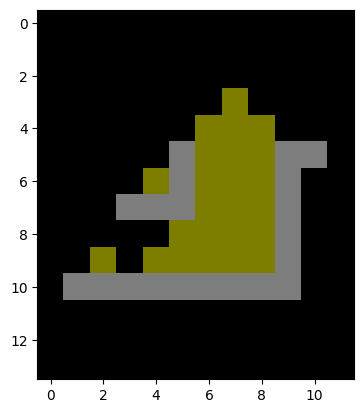

In [35]:
state = run_simulation(CaveScan.parse(example))

pyplot.imshow(state.image())

state.sand_count

In [36]:
state = run_simulation2(CaveScan.parse(example))

pyplot.imshow(state.image())

state.sand_count

93

In [27]:
from aocd import get_data

data = get_data(year=2022, day=14)

state = run_simulation(CaveScan.parse(data))

pyplot.imshow(state.image())

state.sand_count

901

24589

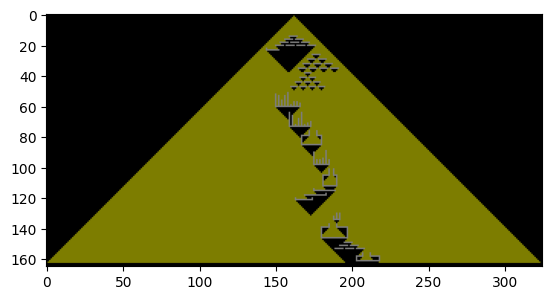

In [37]:
state = run_simulation2(CaveScan.parse(data))

pyplot.imshow(state.image())

state.sand_count